<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part8/P8_Ch04_CH05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nbformat==5.8.0
!pip install nbconvert==7.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled nbformat-5.9.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.5.4
    Uninstalling nbconvert-6.5.4:
      Successfully uninstalled nbconvert-6.5.4


# 흑백 -> 컬러이미지 Colorization Task


  ![PFCN dataset](https://www.researchgate.net/profile/Dawei_Li49/publication/334417334/figure/fig4/AS:832930272276492@1575597460956/Sample-images-from-the-PFCN-dataset.jpg)

     위의 이미지는 다음과 같은 것을 보여줍니다.  
    - 800x600의 사람 portrait 이미지  
     - ?????.png  
    - 사람 영역에 대한 흑백 portrait 이미지
     - ?????_matte.png
    - pfcn_original
     - 원본 800x600 이미지들
    - pfcn_small
     - colab용 100x75 이미지들



- 데이터 출처:
 - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)
 - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

# 1. EDA

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


In [4]:
!ls -al /gdrive/MyDrive/딥러닝_정주행/P8_Ch02.인물사진에서배경없애기

total 161695
-rw------- 1 root root  23713432 Oct 23 10:41 lecture003.h5
-rw------- 1 root root   4572521 Oct 23 10:46 P8_Ch02_CH06,07.ipynb
-rw------- 1 root root 137288603 Oct 12 07:20 pfcn_small.npz


In [5]:
pfcn_small = np.load('/gdrive/MyDrive/딥러닝_정주행/P8_Ch02.인물사진에서배경없애기/pfcn_small.npz')


In [6]:
print(list(pfcn_small.keys()))

train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

['train_images', 'test_images', 'train_mattes', 'test_mattes']


In [7]:
train_images[train_images !=0][:10]

array([0.23627451, 0.34803922, 0.64705882, 0.24509804, 0.35686275,
       0.65588235, 0.25490196, 0.36470588, 0.66470588, 0.2372549 ])

In [8]:
print(train_images.dtype)
print(len(train_images))

float64
1700


In [9]:
print(train_images.shape, test_images.shape)
print(len(train_images), len(test_images))


(1700, 100, 75, 3) (300, 100, 75, 3)
1700 300


In [10]:
train_images[train_images !=0]

array([0.23627451, 0.34803922, 0.64705882, ..., 0.05588235, 0.0245098 ,
       0.01470588])

In [11]:
train_images.dtype, test_images.dtype

(dtype('float64'), dtype('float64'))

In [12]:
print(train_images.min())
print(train_images.max())

print('----------------')
print(test_images.min())
print(test_images.max())

0.0
1.0
----------------
0.0
1.0


# 2. 전처리

- train_gray_images, test_gray_images 생성

In [13]:
from skimage import color

train_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])


print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


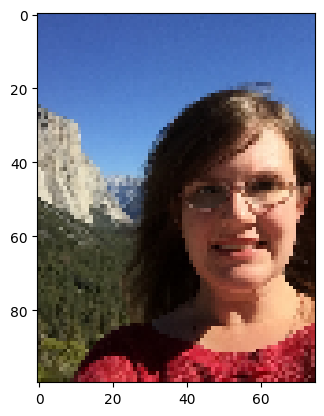

In [14]:
plt.imshow(train_images[0])

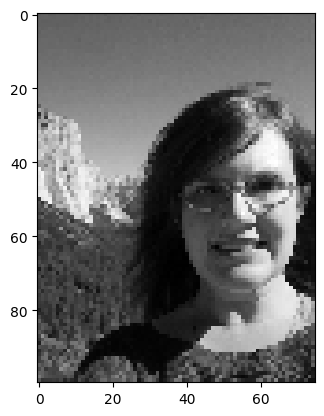

In [15]:
plt.imshow(train_gray_images[0], cmap ='gray')

# 3. Visualization

In [16]:
train_images[:5].shape, train_gray_images[:5].shape

((5, 100, 75, 3), (5, 100, 75, 1))

In [17]:
five = train_images[:5].transpose((1,0,2,3)).reshape((100,-1, 3))

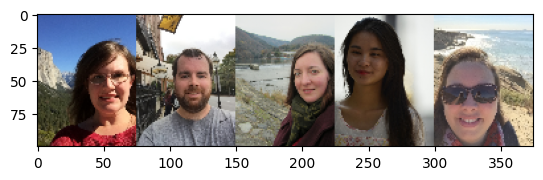

In [18]:
plt.imshow(five)

In [19]:
five_gray = train_gray_images[:5].transpose((1,0,2,3)).reshape((100,-1))

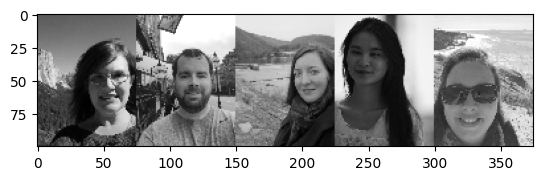

In [20]:
plt.imshow(five_gray, cmap ='gray')

# 4. 흑백 -> 컬러 모델링

In [21]:
from tensorflow import keras
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten
from keras.layers import Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

In [49]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_color():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding = 'valid', output_padding= (0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding = 'valid', output_padding= (1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding = 'valid', output_padding= (0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding = 'valid', output_padding= (0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation ='sigmoid')(c9)

    model = Model(inputs, outputs)

    return model


In [50]:
model = unet_color()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 75, 1)]         0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 100, 75, 16)          160       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 100, 75, 16)          64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 100, 75, 16)          0         ['batch_normalization_18

In [51]:
model.compile(loss = 'mae', optimizer = 'adam', metrics =['accuracy'])

In [52]:
hist = model.fit(train_gray_images, train_images, validation_data =[test_gray_images, test_images], epochs =10, verbose =1)

Epoch 1/10
54/54 [==============================] - 20s 90ms/step - loss: 0.1192 - accuracy: 0.4553 - val_loss: 0.2266 - val_accuracy: 0.6882
Epoch 2/10
54/54 [==============================] - 4s 69ms/step - loss: 0.0706 - accuracy: 0.5793 - val_loss: 0.2159 - val_accuracy: 0.6834
Epoch 3/10
54/54 [==============================] - 4s 68ms/step - loss: 0.0636 - accuracy: 0.6157 - val_loss: 0.2071 - val_accuracy: 0.5916
Epoch 4/10
54/54 [==============================] - 4s 68ms/step - loss: 0.0594 - accuracy: 0.6160 - val_loss: 0.1901 - val_accuracy: 0.6612
Epoch 5/10
54/54 [==============================] - 4s 71ms/step - loss: 0.0569 - accuracy: 0.6225 - val_loss: 0.1738 - val_accuracy: 0.6756
Epoch 6/10
54/54 [==============================] - 4s 69ms/step - loss: 0.0558 - accuracy: 0.6288 - val_loss: 0.1457 - val_accuracy: 0.6277
Epoch 7/10
54/54 [==============================] - 4s 71ms/step - loss: 0.0562 - accuracy: 0.6266 - val_loss: 0.1206 - val_accuracy: 0.5921
Epoch 8/10
5

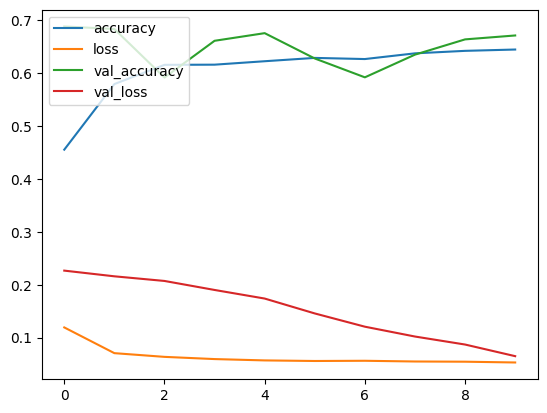

In [53]:
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.legend(loc = 'upper left')
plt.show()

# 5. Colorization 모델 결과 확인

In [54]:
res = model.predict(test_gray_images[0:1])

1/1 [==============================] - 0s 393ms/step


In [55]:
print((test_gray_images[0:1]).shape)
print(res.shape)

(1, 100, 75, 1)
(1, 100, 75, 3)


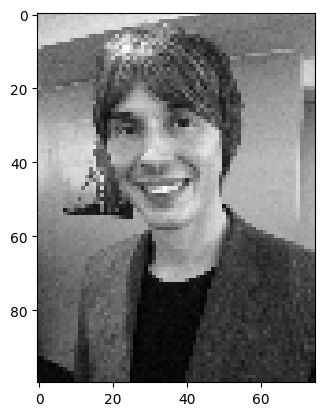

In [56]:
plt.imshow(test_gray_images[0], cmap ='gray')

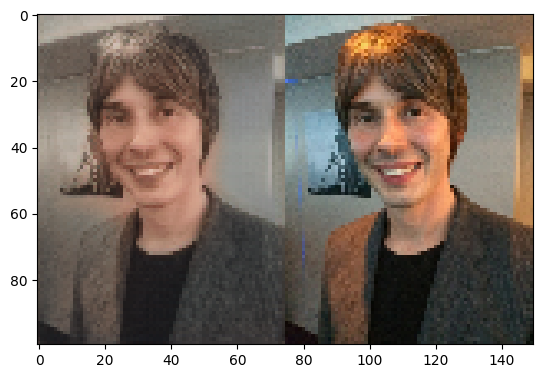

In [57]:
plt.imshow(np.concatenate([res[0], test_images[0]], axis = 1))

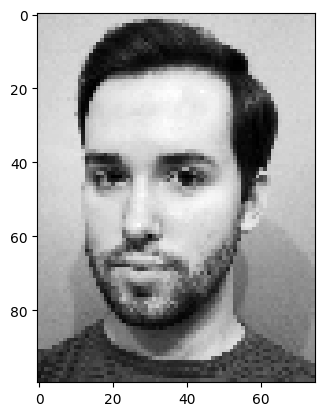

In [58]:
plt.imshow(test_gray_images[1], cmap = 'gray')

In [59]:
res = model.predict(test_gray_images[1:2])

1/1 [==============================] - 0s 21ms/step


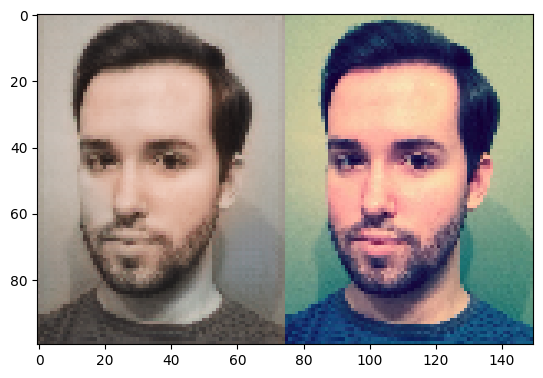

In [60]:
plt.imshow(np.concatenate([res[0], test_images[1]], axis = 1))


1/1 [==============================] - 0s 20ms/step


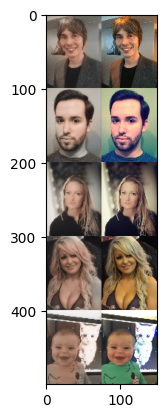

In [74]:
five = model.predict(test_gray_images[:5])
plt.imshow(np.concatenate([five, test_images[:5]], axis =2).reshape((-1, 150, 3)))

- 전반적으로 살색은 잘 예측해 보이지만 배경에 대한 색들이 톤다운되어있다.
- 모델이 오차를 최소화 하는 과정에서 전반적인 배경에 대한 접근이 세피아 톤으로 맞춘것 같다.